In [1]:
import numpy as np
import pandas as pd

def f(x1, x2):
    return (1.3356 * (1.5 * (1 - x1)) 
            + np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2))
            + np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))

def GetGrid(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    y = f(x1, x2)
    return x1, x2, y

def create_dataframe(grid):
   x1, x2, y = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': y.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../../results_f/virtual_samples_RBF.xlsx")

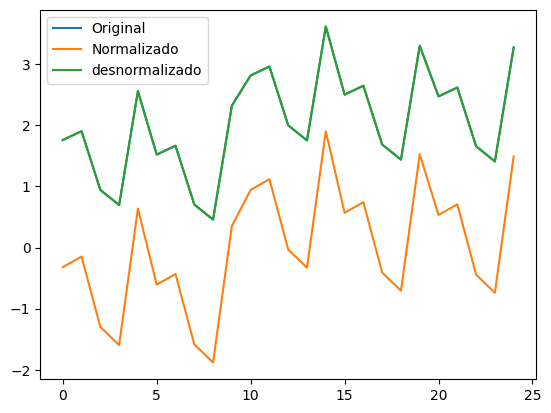

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import tf_levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.lm_model = lm.model.ModelWrapper(self.model)
        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.loss.MeanSquaredError()
        )

        return(self.lm_model)

2025-07-21 22:25:52.877895: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:25:52.882809: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:25:52.897819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753136753.007964    1982 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753136753.050597    1982 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753136753.115169    1982 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)

    def plot_loss_history(self):
      history = self.results.history
      
      plt.figure(figsize=(8, 5))
      plt.plot(history['loss'], label='Loss de Treinamento')
      plt.plot(history['val_loss'], label='Loss de Validação')
      plt.xlabel('Época')
      plt.ylabel('Loss')
      plt.title('Histórico de Loss')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights("./content/models/initial-weights/initial-.weights.h5")
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
      
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"./content/models/{fileName}.weights.h5"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./content/models/initial-weights/initial-.weights.h5",
                f"./content/models/initial-weights/{fileName}.weights.h5")

  def SaveDataset(self, trainer, fileName):
    path = f"./content/dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be >= to acsending metrics
        #trainer.plot_loss_history()
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'./content/results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando Com amostras virtuais



In [ ]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=15)
tester.Loop(sort_by='r2_sup',
            boundarie = 0.5,
            hidden_sizes = [[4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02, 0.2],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[4, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  18
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_2,0.621704,0.569815,0.510232,0.580844,0.252778,0.255377,0.417156,0.250637,0.395601,0.502771,0.379207,0.510689,52.750486,107.110168
model_1_1_1,0.614573,0.564342,0.503611,0.572922,0.257544,0.258625,0.422795,0.255374,0.399413,0.507488,0.367504,0.515480,52.713132,107.072814
model_1_1_5,0.656895,0.545664,0.553974,0.583654,0.229264,0.269714,0.379899,0.248957,0.377510,0.478815,0.436956,0.486356,52.945764,107.305446
model_1_1_4,0.630150,0.525375,0.528311,0.552019,0.247135,0.281758,0.401757,0.267873,0.393596,0.497127,0.393066,0.504956,52.795642,107.155324
model_1_1_0,0.551160,0.524650,0.445467,0.520579,0.299916,0.282188,0.472318,0.286673,0.423189,0.547646,0.263443,0.556271,52.408507,106.768189
model_1_1_3,0.627580,0.523038,0.526193,0.549034,0.248852,0.283146,0.403561,0.269658,0.393766,0.498850,0.388850,0.506707,52.781795,107.141477


DataFrame salvo em ./content/results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_9,0.812388,0.692034,0.691922,0.800094,0.125363,0.182822,0.262402,0.164548,0.265829,0.354066,0.692124,0.359642,54.153086,108.512768
model_1_2_8,0.809159,0.689742,0.688741,0.796736,0.127520,0.184183,0.265112,0.167312,0.267964,0.357100,0.686825,0.362724,54.118957,108.478638
model_1_2_7,0.805790,0.687669,0.685209,0.793354,0.129772,0.185413,0.268121,0.170096,0.270140,0.360239,0.681296,0.365912,54.083954,108.443636
model_1_2_6,0.801993,0.685324,0.681300,0.789492,0.132309,0.186805,0.271450,0.173275,0.272516,0.363742,0.675066,0.369471,54.045237,108.404919
model_1_2_5,0.781464,0.670187,0.661469,0.771378,0.146026,0.195791,0.288341,0.188185,0.279712,0.382134,0.641377,0.388152,53.847936,108.207618
model_1_2_4,0.761421,0.645294,0.646230,0.744394,0.159419,0.210569,0.301321,0.210396,0.298619,0.399273,0.608485,0.405562,53.672435,108.032117
model_1_2_3,0.713159,0.596610,0.604250,0.677791,0.191668,0.239470,0.337076,0.265219,0.346385,0.437799,0.529287,0.444693,53.303986,107.663667
model_1_2_2,0.708385,0.588295,0.601946,0.672306,0.194858,0.244406,0.339039,0.269733,0.349301,0.441427,0.521452,0.448380,53.270966,107.630648
model_1_2_1,0.669786,0.557258,0.565611,0.630204,0.220650,0.262831,0.369987,0.304389,0.369849,0.469734,0.458110,0.477132,53.022354,107.382036
model_1_2_0,0.663589,0.552178,0.559806,0.623346,0.224790,0.265846,0.374931,0.310034,0.373157,0.474121,0.447942,0.481588,52.985173,107.344855


DataFrame salvo em ./content/results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.907398,0.749331,0.790735,0.906993,0.061877,0.148808,0.178240,0.068587,0.186092,0.248751,0.848037,0.252669,55.565210,109.924892
model_1_3_6,0.877818,0.732659,0.760742,0.878945,0.081642,0.158705,0.203786,0.089270,0.213254,0.285731,0.799496,0.290231,55.010817,109.370499
model_1_3_8,0.881047,0.731582,0.764010,0.879888,0.079485,0.159344,0.201002,0.088574,0.215113,0.281930,0.804795,0.286371,55.064379,109.424061
model_1_3_5,0.875849,0.731136,0.758862,0.876555,0.082958,0.159610,0.205387,0.091033,0.216137,0.288024,0.796265,0.292560,54.978845,109.338527
model_1_3_7,0.878904,0.730262,0.761834,0.877848,0.080917,0.160128,0.202856,0.090079,0.216940,0.284459,0.801278,0.288939,55.028666,109.388348
model_1_3_4,0.870167,0.725891,0.752220,0.870086,0.086755,0.162723,0.211044,0.095803,0.223132,0.294541,0.786941,0.299180,54.889343,109.249025
model_1_3_3,0.867959,0.724687,0.750025,0.868134,0.088230,0.163438,0.212914,0.097243,0.224642,0.297035,0.783318,0.301713,54.855617,109.215299
model_1_3_2,0.864705,0.722866,0.746064,0.865089,0.090404,0.164519,0.216287,0.099488,0.227331,0.300673,0.777977,0.305409,54.806923,109.166604
model_1_3_1,0.862071,0.721412,0.743275,0.862613,0.092165,0.165382,0.218663,0.101314,0.229414,0.303586,0.773655,0.308367,54.768358,109.128040
model_1_3_0,0.859770,0.719850,0.741015,0.860379,0.093702,0.166309,0.220588,0.102961,0.231356,0.306108,0.769879,0.310929,54.735271,109.094952


DataFrame salvo em ./content/results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.946423,0.768441,0.831855,0.939395,0.035800,0.137464,0.143216,0.049560,0.147857,0.189209,0.912079,0.192189,56.659613,111.019294
model_1_4_7,0.937468,0.765599,0.821000,0.928831,0.041784,0.139151,0.152462,0.058199,0.159165,0.204412,0.897383,0.207631,56.350473,110.710155
model_1_4_8,0.938630,0.765185,0.822202,0.929989,0.041007,0.139396,0.151438,0.057252,0.158479,0.202503,0.899291,0.205692,56.388004,110.747685
model_1_4_6,0.927135,0.754915,0.812097,0.917514,0.048689,0.145493,0.160045,0.067453,0.171195,0.220655,0.880427,0.224130,56.044621,110.404303
model_1_4_5,0.924654,0.753825,0.809606,0.914847,0.050346,0.146140,0.162166,0.069635,0.173568,0.224380,0.876355,0.227914,55.977657,110.337339
model_1_4_4,0.922564,0.753324,0.807386,0.912622,0.051743,0.146438,0.164058,0.071454,0.174514,0.227471,0.872925,0.231054,55.922927,110.282608
model_1_4_2,0.912237,0.751287,0.795839,0.901975,0.058643,0.147647,0.173893,0.080160,0.182024,0.242164,0.855979,0.245978,55.672561,110.032243
model_1_4_1,0.910561,0.750546,0.794067,0.900142,0.059764,0.148087,0.175402,0.081659,0.183645,0.244466,0.853228,0.248316,55.634718,109.994400
model_1_4_3,0.912094,0.750487,0.794615,0.900854,0.058739,0.148122,0.174935,0.081077,0.186489,0.242362,0.855744,0.246179,55.669297,110.028979
model_1_4_0,0.909177,0.750144,0.792636,0.898750,0.060688,0.148325,0.176620,0.082798,0.184295,0.246349,0.850958,0.250229,55.604024,109.963706


DataFrame salvo em ./content/results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.963236,0.773929,0.849231,0.953836,0.024566,0.134205,0.128417,0.024514,0.129500,0.156734,0.939670,0.159202,57.412820,111.772502
model_1_5_8,0.962504,0.773920,0.848361,0.952898,0.025055,0.134211,0.129157,0.025012,0.130718,0.158288,0.938468,0.160781,57.373357,111.733039
model_1_5_7,0.961793,0.773867,0.847516,0.951995,0.025530,0.134243,0.129877,0.025491,0.131916,0.159781,0.937301,0.162298,57.335794,111.695475
model_1_5_4,0.959421,0.773797,0.844741,0.948955,0.027115,0.134284,0.132241,0.027106,0.135957,0.164666,0.933409,0.167259,57.215349,111.575031
model_1_5_6,0.961096,0.773780,0.846731,0.951122,0.025996,0.134294,0.130545,0.025955,0.133135,0.161231,0.936158,0.163771,57.299659,111.659341
model_1_5_5,0.960282,0.773775,0.845788,0.950089,0.026539,0.134297,0.131349,0.026503,0.134530,0.162909,0.934822,0.165475,57.258251,111.617932
model_1_5_3,0.958707,0.773629,0.843941,0.948073,0.027592,0.134384,0.132922,0.027574,0.137211,0.166109,0.932236,0.168726,57.180433,111.540115
model_1_5_2,0.958104,0.770723,0.846166,0.950263,0.027995,0.136109,0.131027,0.026411,0.134620,0.167317,0.931248,0.169952,57.151468,111.511150
model_1_5_1,0.955135,0.769438,0.844146,0.947858,0.029979,0.136871,0.132748,0.027688,0.136614,0.173144,0.926376,0.175871,57.014531,111.374212
model_1_5_0,0.947482,0.768659,0.833057,0.936407,0.035093,0.137334,0.142192,0.033769,0.146471,0.187331,0.913816,0.190281,56.699511,111.059192


DataFrame salvo em ./content/results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_1,0.966461,0.773347,0.852669,0.965772,0.022411,0.134551,0.125488,0.029481,0.124227,0.149703,0.944961,0.152061,57.596399,111.956081
model_1_6_2,0.967247,0.773331,0.853802,0.966653,0.021885,0.134561,0.124523,0.028722,0.122677,0.147937,0.946252,0.150267,57.643874,112.003556
model_1_6_0,0.966041,0.773285,0.852353,0.965319,0.022691,0.134588,0.125757,0.029871,0.124863,0.150637,0.944273,0.153009,57.571535,111.931217
model_1_6_3,0.968141,0.772917,0.854843,0.967659,0.021288,0.134806,0.123636,0.027856,0.121461,0.145906,0.947718,0.148203,57.699183,112.058865
model_1_6_4,0.969480,0.772825,0.856205,0.969079,0.020394,0.134861,0.122476,0.026632,0.119174,0.142806,0.949916,0.145055,57.785075,112.144757
model_1_6_5,0.970084,0.772757,0.856903,0.969709,0.019990,0.134901,0.121882,0.026090,0.117994,0.141385,0.950908,0.143612,57.825079,112.184761
model_1_6_6,0.970684,0.772705,0.857642,0.970348,0.019589,0.134932,0.121252,0.025539,0.116816,0.139960,0.951892,0.142164,57.865591,112.225273
model_1_6_7,0.971277,0.772631,0.858336,0.970965,0.019193,0.134976,0.120661,0.025008,0.115617,0.138538,0.952865,0.140720,57.906431,112.266113
model_1_6_8,0.971779,0.772614,0.858977,0.971528,0.018857,0.134986,0.120115,0.024523,0.114666,0.137322,0.953689,0.139484,57.941716,112.301398
model_1_6_9,0.972345,0.772538,0.859661,0.972118,0.018479,0.135031,0.119533,0.024014,0.113511,0.135938,0.954617,0.138079,57.982212,112.341893


DataFrame salvo em ./content/results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_1,0.976654,0.774609,0.863926,0.980026,0.015600,0.133802,0.115899,0.017383,0.102440,0.124899,0.961689,0.126866,58.320996,112.680677
model_1_7_4,0.978951,0.774427,0.866790,0.982185,0.014065,0.133910,0.113461,0.015504,0.096809,0.118595,0.965459,0.120462,58.528175,112.887857
model_1_7_3,0.978695,0.774335,0.866562,0.981908,0.014236,0.133965,0.113654,0.015745,0.097484,0.119314,0.965038,0.121193,58.503980,112.863662
model_1_7_5,0.979367,0.774289,0.867333,0.982546,0.013787,0.133992,0.112998,0.015190,0.095842,0.117418,0.966141,0.119268,58.568049,112.927731
model_1_7_2,0.977668,0.774243,0.865339,0.980891,0.014922,0.134019,0.114696,0.016630,0.100141,0.122157,0.963353,0.124081,58.409796,112.769478
model_1_7_6,0.981427,0.773375,0.869492,0.984231,0.012411,0.134534,0.111159,0.013723,0.091808,0.111403,0.969521,0.113157,58.778422,113.138103
model_1_7_0,0.974547,0.772770,0.862042,0.977407,0.017008,0.134893,0.117504,0.019661,0.108798,0.130414,0.958231,0.132468,58.148171,112.507853
model_1_7_7,0.984419,0.770730,0.873990,0.986333,0.010411,0.136105,0.107327,0.011894,0.085570,0.102036,0.974431,0.103643,59.129719,113.489401
model_1_7_8,0.984742,0.770533,0.874469,0.986605,0.010195,0.136221,0.106920,0.011657,0.084703,0.100971,0.974962,0.102561,59.171679,113.531361
model_1_7_9,0.985075,0.770370,0.874967,0.986905,0.009973,0.136318,0.106496,0.011396,0.083722,0.099864,0.975508,0.101437,59.215786,113.575467


DataFrame salvo em ./content/results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.985728,0.769862,0.875767,0.984188,0.009537,0.136620,0.105815,0.015427,0.081905,0.097656,0.976579,0.099194,59.305220,113.664902
model_1_8_4,0.989489,0.768522,0.882072,0.988714,0.007024,0.137416,0.100444,0.011011,0.065064,0.083807,0.982751,0.085127,59.916936,114.276618
model_1_8_8,0.991063,0.768481,0.883826,0.990538,0.005972,0.137440,0.098950,0.009232,0.058271,0.077278,0.985334,0.078495,60.241400,114.601082
model_1_8_5,0.989671,0.768370,0.882262,0.988890,0.006902,0.137505,0.100282,0.010839,0.064629,0.083077,0.983050,0.084386,59.951936,114.311618
model_1_8_1,0.987599,0.768240,0.878555,0.986491,0.008286,0.137583,0.103440,0.013180,0.074970,0.091029,0.979650,0.092463,59.586289,113.945971
model_1_8_9,0.991805,0.768173,0.884631,0.991272,0.005476,0.137622,0.098264,0.008516,0.055887,0.074001,0.986551,0.075167,60.414700,114.774382
model_1_8_6,0.990574,0.767977,0.883653,0.989906,0.006298,0.137739,0.099098,0.009848,0.060778,0.079363,0.984532,0.080613,60.134903,114.494585
model_1_8_3,0.989309,0.767846,0.880822,0.988244,0.007144,0.137816,0.101509,0.011470,0.069362,0.084522,0.982455,0.085853,59.882971,114.242653
model_1_8_2,0.989103,0.767826,0.880331,0.988043,0.007281,0.137829,0.101927,0.011666,0.070112,0.085331,0.982118,0.086675,59.844885,114.204566
model_1_8_7,0.990822,0.767595,0.883951,0.990152,0.006132,0.137966,0.098844,0.009608,0.060232,0.078310,0.984939,0.079543,60.188310,114.547992


DataFrame salvo em ./content/results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_0,0.991964,0.767946,0.884890,0.991531,0.005370,0.137757,0.098044,0.007018,0.055309,0.073279,0.986813,0.074433,60.453943,114.813625
model_1_9_2,0.992615,0.766830,0.885966,0.992138,0.004935,0.138420,0.097128,0.006515,0.052872,0.070249,0.987880,0.071356,60.622819,114.982501
model_1_9_3,0.992716,0.766736,0.886098,0.992245,0.004867,0.138476,0.097015,0.006426,0.052505,0.069765,0.988047,0.070864,60.650471,115.010153
model_1_9_1,0.992584,0.766725,0.886031,0.992085,0.004955,0.138482,0.097072,0.006559,0.052929,0.070393,0.987831,0.071502,60.614639,114.974320
model_1_9_4,0.992800,0.766680,0.886187,0.992335,0.004811,0.138509,0.096939,0.006352,0.052225,0.069360,0.988185,0.070452,60.673790,115.033472
model_1_9_5,0.992939,0.766360,0.886668,0.992481,0.004718,0.138699,0.096529,0.006231,0.051485,0.068691,0.988412,0.069773,60.712566,115.072248
model_1_9_6,0.993158,0.766131,0.886900,0.992708,0.004572,0.138834,0.096332,0.006043,0.050804,0.067615,0.988772,0.068680,60.775707,115.135388
model_1_9_7,0.993277,0.765951,0.887106,0.992831,0.004492,0.138941,0.096157,0.005941,0.050325,0.067023,0.988968,0.068079,60.810854,115.170536
model_1_9_8,0.994410,0.764158,0.889175,0.994027,0.003735,0.140006,0.094394,0.004950,0.045603,0.061116,0.990827,0.062078,61.179937,115.539618
model_1_9_9,0.994618,0.763788,0.889466,0.994237,0.003596,0.140226,0.094147,0.004776,0.044885,0.059968,0.991168,0.060912,61.255805,115.615486


DataFrame salvo em ./content/results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_0,0.995765,0.761257,0.891049,0.995968,0.002830,0.141728,0.092798,0.001900,0.039550,0.053195,0.993051,0.054033,61.735160,116.094842
model_1_10_1,0.996150,0.759695,0.891676,0.996336,0.002573,0.142655,0.092264,0.001726,0.037633,0.050720,0.993682,0.051519,61.925738,116.285420
model_1_10_2,0.996389,0.758914,0.892052,0.996581,0.002413,0.143119,0.091943,0.001610,0.036490,0.049122,0.994074,0.049896,62.053757,116.413438
model_1_10_3,0.996726,0.757892,0.892274,0.996739,0.002188,0.143726,0.091754,0.001536,0.035595,0.046772,0.994628,0.047508,62.249905,116.609587
model_1_10_4,0.996743,0.757892,0.892229,0.996755,0.002176,0.143726,0.091793,0.001529,0.035485,0.046651,0.994655,0.047386,62.260253,116.619935
model_1_10_5,0.997216,0.756362,0.892793,0.997270,0.001860,0.144634,0.091313,0.001286,0.032784,0.043130,0.995432,0.043809,62.574154,116.933835
model_1_10_6,0.997403,0.755817,0.892819,0.997443,0.001735,0.144958,0.091291,0.001204,0.031755,0.041659,0.995738,0.042315,62.712983,117.072664
model_1_10_7,0.997440,0.755675,0.892862,0.997485,0.001710,0.145042,0.091253,0.001185,0.031512,0.041356,0.995800,0.042007,62.742147,117.101829
model_1_10_8,0.998225,0.751659,0.894181,0.998208,0.001186,0.147426,0.090131,0.000844,0.026644,0.034443,0.997087,0.034986,63.473777,117.833458
model_1_10_9,0.998374,0.750988,0.894334,0.998378,0.001086,0.147824,0.090000,0.000764,0.025419,0.032957,0.997332,0.033476,63.650175,118.009857


DataFrame salvo em ./content/results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_0,0.998462,0.750471,0.894636,0.998518,0.001028,0.148131,0.089743,0.000883,0.024617,0.032062,0.997475,0.032567,63.760284,118.119966
model_1_11_1,0.998471,0.750378,0.894681,0.998519,0.001021,0.148186,0.089704,0.000883,0.024624,0.031959,0.997492,0.032462,63.773252,118.132934
model_1_11_2,0.998495,0.750262,0.894728,0.998540,0.001006,0.148255,0.089665,0.000871,0.024424,0.031714,0.997530,0.032214,63.803948,118.163630
model_1_11_3,0.998655,0.749403,0.895130,0.998697,0.000899,0.148765,0.089322,0.000777,0.022873,0.029980,0.997793,0.030452,64.028885,118.388567
model_1_11_4,0.998676,0.749307,0.895143,0.998715,0.000885,0.148822,0.089311,0.000766,0.022664,0.029743,0.997827,0.030212,64.060594,118.420276
model_1_11_5,0.998824,0.748359,0.895482,0.998846,0.000786,0.149385,0.089023,0.000688,0.021303,0.028033,0.998070,0.028474,64.297497,118.657179
model_1_11_6,0.998923,0.747485,0.896029,0.998917,0.000720,0.149904,0.088556,0.000646,0.020479,0.026825,0.998233,0.027248,64.473658,118.833340
model_1_11_7,0.999089,0.745502,0.897279,0.999125,0.000609,0.151081,0.087492,0.000522,0.018180,0.024670,0.998505,0.025058,64.808700,119.168382
model_1_11_8,0.999139,0.745332,0.897323,0.999178,0.000575,0.151182,0.087454,0.000490,0.017322,0.023988,0.998587,0.024366,64.920843,119.280525
model_1_11_9,0.999186,0.744967,0.897387,0.999211,0.000544,0.151399,0.087400,0.000470,0.016880,0.023316,0.998665,0.023683,65.034540,119.394222


DataFrame salvo em ./content/results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_1,0.999320,0.743743,0.897634,0.999161,0.000455,0.152125,0.087189,0.000292,0.015482,0.021322,0.998884,0.021658,65.392110,119.751792
model_1_12_0,0.999317,0.743739,0.897661,0.999161,0.000456,0.152128,0.087166,0.000292,0.015514,0.021365,0.998879,0.021702,65.383990,119.743672
model_1_12_2,0.999327,0.743687,0.897643,0.999164,0.000450,0.152158,0.087182,0.000291,0.015383,0.021208,0.998895,0.021543,65.413413,119.773095
model_1_12_3,0.999404,0.743027,0.897796,0.999187,0.000398,0.152550,0.087052,0.000283,0.014272,0.019959,0.999022,0.020273,65.656326,120.016008
model_1_12_4,0.999452,0.742524,0.897926,0.999196,0.000366,0.152849,0.086941,0.000280,0.013571,0.019141,0.999100,0.019442,65.823737,120.183419
model_1_12_5,0.999458,0.742453,0.897940,0.999197,0.000362,0.152891,0.086929,0.000280,0.013484,0.019031,0.999111,0.019331,65.846751,120.206432
model_1_12_6,0.999505,0.741837,0.898020,0.999169,0.000331,0.153256,0.086860,0.000289,0.012937,0.018192,0.999187,0.018479,66.027036,120.386718
model_1_12_8,0.999522,0.741210,0.898333,0.999017,0.000319,0.153629,0.086594,0.000342,0.012760,0.017872,0.999216,0.018154,66.098041,120.457723
model_1_12_9,0.999526,0.741160,0.898342,0.999019,0.000316,0.153659,0.086586,0.000342,0.012676,0.017789,0.999223,0.018069,66.116650,120.476332
model_1_12_7,0.999517,0.740970,0.899024,0.999112,0.000323,0.153771,0.086006,0.000309,0.011947,0.017963,0.999208,0.018246,66.077825,120.437507


DataFrame salvo em ./content/results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_2,0.999539,0.741206,0.898344,0.999435,0.000308,0.153631,0.086584,0.000330,0.012360,0.017560,0.999243,0.017836,66.168636,120.528318
model_1_13_0,0.999531,0.741127,0.898360,0.999460,0.000313,0.153678,0.086571,0.000315,0.012580,0.017702,0.999230,0.017981,66.136351,120.496033
model_1_13_1,0.999531,0.741075,0.898460,0.999445,0.000314,0.153709,0.086486,0.000324,0.012477,0.017706,0.999230,0.017985,66.135387,120.495069
model_1_13_3,0.999559,0.741057,0.898375,0.999443,0.000295,0.153720,0.086558,0.000325,0.011978,0.017169,0.999276,0.017439,66.258674,120.618355
model_1_13_4,0.999563,0.740976,0.898422,0.999446,0.000292,0.153768,0.086518,0.000324,0.011883,0.017079,0.999284,0.017348,66.279512,120.639194
model_1_13_5,0.999571,0.740873,0.898483,0.999448,0.000286,0.153829,0.086466,0.000322,0.011702,0.016921,0.999297,0.017188,66.316720,120.676402
model_1_13_6,0.999579,0.740726,0.898442,0.999467,0.000282,0.153916,0.086501,0.000312,0.011713,0.016780,0.999309,0.017044,66.350358,120.710040
model_1_13_7,0.999597,0.740640,0.898481,0.999471,0.000269,0.153967,0.086468,0.000309,0.011291,0.016415,0.999338,0.016673,66.438308,120.797989
model_1_13_8,0.999601,0.740587,0.898505,0.999474,0.000267,0.153999,0.086448,0.000308,0.011201,0.016331,0.999345,0.016588,66.458705,120.818387
model_1_13_9,0.999617,0.740464,0.898532,0.999481,0.000256,0.154072,0.086425,0.000304,0.010822,0.015990,0.999372,0.016242,66.543105,120.902787


DataFrame salvo em ./content/results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_4,0.999657,0.740817,0.899122,0.999424,0.000229,0.153862,0.085922,0.000310,0.009940,0.015136,0.999437,0.015374,66.762821,121.122502
model_1_14_3,0.999655,0.740805,0.899117,0.999426,0.000230,0.153870,0.085927,0.000309,0.009948,0.015176,0.999434,0.015415,66.752071,121.111753
model_1_14_2,0.999641,0.740635,0.898982,0.999421,0.000240,0.153970,0.086041,0.000311,0.010202,0.015483,0.999411,0.015727,66.672122,121.031804
model_1_14_1,0.999633,0.740477,0.898737,0.999405,0.000245,0.154064,0.086250,0.000319,0.010430,0.015664,0.999397,0.015910,66.625653,120.985334
model_1_14_0,0.999631,0.740463,0.898700,0.999403,0.000247,0.154073,0.086282,0.000321,0.010466,0.015701,0.999395,0.015949,66.616054,120.975735
model_1_14_9,0.999750,0.737998,0.900746,0.999612,0.000167,0.155536,0.084539,0.000209,0.008303,0.012915,0.999590,0.013118,67.397436,121.757118
model_1_14_8,0.999747,0.737726,0.900810,0.999625,0.000169,0.155697,0.084484,0.000201,0.008339,0.013003,0.999585,0.013208,67.370200,121.729881
model_1_14_7,0.999741,0.736857,0.901411,0.999688,0.000173,0.156213,0.083973,0.000167,0.008314,0.013162,0.999575,0.013369,67.321652,121.681334
model_1_14_6,0.999734,0.736664,0.901429,0.999694,0.000177,0.156328,0.083957,0.000165,0.008390,0.013320,0.999564,0.013530,67.274027,121.633709
model_1_14_5,0.999733,0.736562,0.901454,0.999696,0.000179,0.156388,0.083936,0.000164,0.008411,0.013368,0.999561,0.013578,67.259581,121.619263


DataFrame salvo em ./content/results/metrics_1_14
Testando combinacao2: Hidden Size=[4, 2], regularizer=0.02, learning_rate=0.1


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_0_5,0.986558,0.746299,0.856193,0.967292,0.008982,0.150608,0.122486,0.016199,0.069967,0.094772,0.977942,0.096265,59.425122,113.784804
model_2_0_6,0.987170,0.745784,0.856206,0.968314,0.008573,0.150914,0.122475,0.015693,0.066656,0.092592,0.978945,0.094051,59.518194,113.877876
model_2_0_4,0.981830,0.741038,0.846784,0.965631,0.012141,0.153731,0.130501,0.017021,0.081066,0.110188,0.970182,0.111923,58.822277,113.181959
model_2_0_7,0.994606,0.730747,0.875389,0.983001,0.003604,0.159840,0.106136,0.008419,0.032153,0.060037,0.991148,0.060982,61.251195,115.610877
model_2_0_8,0.995218,0.725304,0.880015,0.981212,0.003196,0.163071,0.102196,0.009305,0.025649,0.056530,0.992152,0.057420,61.491958,115.851640
model_2_0_3,0.955099,0.721109,0.822464,0.905147,0.030003,0.165562,0.151215,0.046976,0.144450,0.173214,0.926316,0.175942,57.012905,111.372586
model_2_0_2,0.909807,0.709798,0.759135,0.815820,0.060268,0.172276,0.205154,0.091216,0.210743,0.245494,0.851990,0.249361,55.617924,109.977606
model_2_0_1,0.758045,0.615334,0.636325,0.506627,0.161675,0.228354,0.309757,0.244344,0.349300,0.402089,0.602945,0.408421,53.644332,108.004014
model_2_0_0,0.730994,0.557148,0.631071,0.542871,0.179751,0.262896,0.314232,0.226393,0.277403,0.423970,0.558554,0.430647,53.432367,107.792049


DataFrame salvo em ./content/results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_0,0.995410,0.720792,0.881187,0.993247,0.003067,0.165750,0.101198,0.003974,0.025863,0.055381,0.992468,0.056253,61.574085,115.933767
model_2_1_1,0.996229,0.703932,0.886011,0.989214,0.002520,0.175759,0.097089,0.006347,0.023951,0.050197,0.993812,0.050988,61.967168,116.326850
model_2_1_2,0.996296,0.702280,0.885466,0.988969,0.002475,0.176739,0.097553,0.006491,0.023796,0.049746,0.993922,0.050530,62.003281,116.362963
model_2_1_8,0.996157,0.697219,0.883662,0.986463,0.002568,0.179744,0.099090,0.007965,0.024905,0.050676,0.993693,0.051474,61.929197,116.288879
model_2_1_6,0.996167,0.696911,0.883649,0.986575,0.002561,0.179927,0.099101,0.007899,0.024723,0.050606,0.993711,0.051403,61.934752,116.294434
model_2_1_7,0.996153,0.696727,0.883603,0.986465,0.002571,0.180036,0.099140,0.007964,0.024724,0.050701,0.993687,0.051500,61.927201,116.286883
model_2_1_4,0.996322,0.696725,0.884292,0.988059,0.002458,0.180037,0.098553,0.007026,0.023538,0.049576,0.993964,0.050357,62.016997,116.376679
model_2_1_3,0.996323,0.696656,0.884442,0.988159,0.002457,0.180078,0.098426,0.006967,0.023505,0.049569,0.993966,0.050350,62.017525,116.377207
model_2_1_9,0.996065,0.696632,0.883411,0.985886,0.002629,0.180093,0.099304,0.008305,0.025101,0.051274,0.993543,0.052082,61.882270,116.241951
model_2_1_5,0.996233,0.695815,0.883434,0.987242,0.002517,0.180577,0.099284,0.007506,0.024094,0.050168,0.993819,0.050958,61.969492,116.329174


DataFrame salvo em ./content/results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_8,0.996359,0.728361,0.891242,0.992547,0.002433,0.161257,0.092633,0.006486,0.024618,0.049324,0.994025,0.050100,62.037403,116.397085
model_2_2_9,0.996370,0.728075,0.891466,0.992550,0.002425,0.161427,0.092443,0.006483,0.024579,0.049247,0.994044,0.050023,62.043616,116.403298
model_2_2_7,0.996300,0.724259,0.892672,0.992425,0.002473,0.163692,0.091415,0.006592,0.024767,0.049726,0.993927,0.050509,62.004909,116.364590
model_2_2_6,0.996358,0.722383,0.893340,0.992755,0.002434,0.164806,0.090847,0.006304,0.024531,0.049331,0.994024,0.050108,62.036815,116.396496
model_2_2_5,0.996359,0.722000,0.893451,0.992804,0.002433,0.165033,0.090752,0.006262,0.024526,0.049322,0.994026,0.050098,62.037575,116.397257
model_2_2_4,0.996270,0.718737,0.895327,0.993437,0.002492,0.166970,0.089154,0.005711,0.025825,0.049924,0.993879,0.050710,61.989021,116.348703
model_2_2_3,0.996149,0.717843,0.895577,0.993477,0.002573,0.167501,0.088941,0.005676,0.026338,0.050728,0.993680,0.051527,61.925097,116.284779
model_2_2_2,0.996603,0.706312,0.889072,0.996452,0.002270,0.174346,0.094482,0.003087,0.023957,0.047641,0.994426,0.048391,62.176251,116.535933
model_2_2_1,0.996452,0.702498,0.887737,0.996780,0.002371,0.176610,0.095619,0.002803,0.024382,0.048694,0.994177,0.049461,62.088804,116.448486
model_2_2_0,0.996286,0.699373,0.885042,0.997343,0.002482,0.178465,0.097914,0.002312,0.024510,0.049815,0.993906,0.050599,61.997770,116.357452


DataFrame salvo em ./content/results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_9,0.996770,0.731956,0.900845,0.991862,0.002158,0.159123,0.084454,0.005699,0.023781,0.046454,0.994700,0.047186,62.277166,116.636848
model_2_3_7,0.996799,0.731251,0.900048,0.992039,0.002139,0.159541,0.085133,0.005575,0.023794,0.046248,0.994747,0.046977,62.294907,116.654589
model_2_3_8,0.996790,0.731225,0.900177,0.991990,0.002145,0.159556,0.085023,0.005610,0.023793,0.046313,0.994732,0.047042,62.289350,116.649032
model_2_3_6,0.996760,0.730595,0.899655,0.991919,0.002165,0.159931,0.085468,0.005660,0.023760,0.046528,0.994683,0.047261,62.270790,116.630471
model_2_3_5,0.996751,0.730240,0.899584,0.991925,0.002171,0.160141,0.085528,0.005655,0.023833,0.046596,0.994668,0.047330,62.264940,116.624622
model_2_3_4,0.996776,0.730120,0.897505,0.992307,0.002154,0.160212,0.087299,0.005388,0.023920,0.046412,0.994710,0.047143,62.280794,116.640476
model_2_3_1,0.996770,0.729487,0.895298,0.993732,0.002159,0.160588,0.089179,0.004390,0.024999,0.046461,0.994699,0.047193,62.276580,116.636262
model_2_3_3,0.996746,0.729322,0.897592,0.992302,0.002174,0.160686,0.087225,0.005391,0.024028,0.046627,0.994661,0.047361,62.262292,116.621973
model_2_3_0,0.996452,0.728804,0.891545,0.994662,0.002371,0.160994,0.092375,0.003739,0.024508,0.048694,0.994177,0.049461,62.088792,116.448474
model_2_3_2,0.996745,0.725294,0.898283,0.992942,0.002175,0.163077,0.086637,0.004943,0.024713,0.046639,0.994658,0.047373,62.261279,116.620961


DataFrame salvo em ./content/results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_0,0.997012,0.730909,0.901206,0.997821,0.001997,0.159744,0.084147,0.001126,0.023472,0.044687,0.995096,0.045391,62.432313,116.791995
model_2_4_1,0.997423,0.724654,0.898234,0.996805,0.001722,0.163457,0.086679,0.001650,0.021387,0.041495,0.995771,0.042149,62.728704,117.088386
model_2_4_2,0.997430,0.724592,0.898067,0.996687,0.001717,0.163494,0.086821,0.001711,0.021269,0.041443,0.995782,0.042095,62.733791,117.093473
model_2_4_4,0.997284,0.723780,0.898481,0.995206,0.001815,0.163976,0.086468,0.002477,0.021449,0.042604,0.995542,0.043275,62.623239,116.982921
model_2_4_3,0.997333,0.723426,0.898177,0.995730,0.001782,0.164186,0.086727,0.002206,0.021181,0.042213,0.995624,0.042877,62.660142,117.019824
model_2_4_5,0.997291,0.723118,0.898912,0.995134,0.001810,0.164369,0.086101,0.002513,0.021242,0.042549,0.995554,0.043219,62.628372,116.988054
model_2_4_7,0.997304,0.722642,0.898916,0.995158,0.001801,0.164652,0.086098,0.002501,0.021072,0.042443,0.995576,0.043111,62.638399,116.998081
model_2_4_9,0.997305,0.722612,0.898945,0.995155,0.001800,0.164669,0.086073,0.002503,0.021093,0.042432,0.995578,0.043101,62.639387,116.999069
model_2_4_8,0.997305,0.722606,0.898881,0.995153,0.001801,0.164673,0.086127,0.002504,0.021078,0.042435,0.995578,0.043103,62.639168,116.998850
model_2_4_6,0.997306,0.722601,0.898863,0.995184,0.001800,0.164676,0.086143,0.002488,0.021016,0.042431,0.995578,0.043099,62.639510,116.999191


DataFrame salvo em ./content/results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_0,0.997214,0.711859,0.898127,0.993879,0.001862,0.171053,0.086769,0.003468,0.022202,0.043149,0.995428,0.043829,62.572387,116.932068
model_2_5_1,0.996946,0.705415,0.896800,0.991725,0.002041,0.174878,0.087900,0.004689,0.023613,0.045177,0.994988,0.045888,62.388683,116.748365
model_2_5_2,0.996914,0.704218,0.896180,0.991065,0.002062,0.175589,0.088428,0.005063,0.023930,0.045409,0.994936,0.046124,62.368150,116.727831
model_2_5_3,0.996903,0.704016,0.896130,0.990963,0.002070,0.175709,0.088471,0.005120,0.023998,0.045495,0.994917,0.046211,62.360649,116.720330
model_2_5_4,0.996801,0.702511,0.895890,0.990278,0.002137,0.176602,0.088675,0.005509,0.024454,0.046232,0.994751,0.046961,62.296298,116.655980
model_2_5_8,0.996731,0.702488,0.895301,0.989745,0.002184,0.176616,0.089177,0.005811,0.024573,0.046735,0.994636,0.047471,62.253029,116.612711
model_2_5_7,0.996740,0.702467,0.895403,0.989820,0.002178,0.176628,0.089090,0.005768,0.024561,0.046674,0.994650,0.047409,62.258268,116.617950
model_2_5_9,0.996725,0.702387,0.895255,0.989705,0.002188,0.176676,0.089215,0.005833,0.024594,0.046780,0.994626,0.047517,62.249205,116.608887
model_2_5_6,0.996751,0.702256,0.895625,0.989925,0.002171,0.176754,0.088900,0.005709,0.024606,0.046593,0.994669,0.047327,62.265227,116.624909
model_2_5_5,0.996752,0.702178,0.895573,0.989939,0.002170,0.176800,0.088944,0.005701,0.024580,0.046584,0.994671,0.047318,62.266003,116.625684


DataFrame salvo em ./content/results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_7,0.996334,0.734090,0.890138,0.983510,0.002450,0.157856,0.093574,0.007913,0.022333,0.049493,0.993984,0.050272,62.023694,116.383376
model_2_6_6,0.996334,0.734067,0.890053,0.983520,0.002449,0.157869,0.093646,0.007908,0.022313,0.049491,0.993985,0.050270,62.023858,116.383540
model_2_6_4,0.996368,0.734058,0.890513,0.983855,0.002427,0.157875,0.093254,0.007747,0.022213,0.049263,0.994040,0.050039,62.042299,116.401981
model_2_6_5,0.996363,0.734041,0.890165,0.983771,0.002430,0.157885,0.093551,0.007787,0.022314,0.049297,0.994032,0.050074,62.039528,116.399210
model_2_6_3,0.996442,0.734022,0.890684,0.984524,0.002377,0.157896,0.093109,0.007426,0.022260,0.048758,0.994161,0.049526,62.083512,116.443194
model_2_6_9,0.996332,0.733891,0.890173,0.983479,0.002451,0.157974,0.093544,0.007927,0.022316,0.049511,0.993980,0.050290,62.022279,116.381961
model_2_6_8,0.996332,0.733880,0.890138,0.983486,0.002451,0.157981,0.093574,0.007924,0.022303,0.049510,0.993980,0.050290,62.022337,116.382019
model_2_6_2,0.996453,0.733671,0.890856,0.984692,0.002370,0.158104,0.092963,0.007345,0.022255,0.048685,0.994179,0.049452,62.089518,116.449199
model_2_6_1,0.996474,0.733648,0.890932,0.984850,0.002356,0.158118,0.092897,0.007270,0.022241,0.048542,0.994213,0.049306,62.101329,116.461011
model_2_6_0,0.996680,0.731612,0.891730,0.986927,0.002219,0.159327,0.092218,0.006273,0.022172,0.047103,0.994551,0.047845,62.221694,116.581376


DataFrame salvo em ./content/results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━